# 8.3 Leveraging a pretrained model

2 ways to use a pretrained model:
1. *Feature extraction*
2. *Fine-tuning*

## 8.3.1 Feature extraction with a pretrained model

### Instantiating the VGG16 convolutional base

In [1]:
from tensorflow import keras

In [2]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top=False, #not including the densely connected layer from ImageNet
    input_shape=(180, 180, 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Fast feature extraction without data augmentation

- Recording the output of `conv_base` on our data and using these outputs as inputs to a new model (densely connected classifier).

### Extracting the VGG16 features and corresponding labels

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ronnetawat","key":"b4ba7ead4e8f8fe51222412489046910"}'}

In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

 99% 806M/812M [00:08<00:00, 151MB/s]
100% 812M/812M [00:08<00:00, 100MB/s]


In [10]:
import os, shutil, pathlib

original_dir = pathlib.Path("train") #path to directory where original dataset was uncompressed
new_base_dir = pathlib.Path("cats_vs_dogs_small") # directory to store our smaller dataset

# utility func to copy cat/dog images from start_index to end_index to the subdir
# new_base_dir/{subset_name}/cat(and /dog)
# subset_name options: "train", "validation", "test"
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000) #create training subset w/ first 1000 images of each category
make_subset("validation", start_index=1000, end_index=1500) #create validation subset w/ 500 images of each category
make_subset("test", start_index=1500, end_index=2500) # create test subset w/ 1000 images of each category

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

# this returns a tf.data.Dataset object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [4]:
import numpy as np

def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)

  return np.concatenate(all_features), np.concatenate(all_labels)

In [12]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_featuers, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [13]:
train_features.shape

(2000, 5, 5, 512)

### Defining and training the densely connected classifier

Now we can define our densely connected classifier and train it on the data and labels we just recorded.

In [14]:
from tensorflow.keras import layers

In [16]:
inputs = keras.Input(shape=(5, 5, 512))

#flattening the layer before passing the features to the Dense layer
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x) # adding Dropout for regularization

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)



In [17]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"]
              )

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="feature_extraction.keras",
                                    save_best_only=True,
                                    monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20, validation_data=(val_featuers, val_labels),
    callbacks=callbacks
)

# training is fast as we only are dealing with 2 Dense layers

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8568 - loss: 51.1226 - val_accuracy: 0.9490 - val_loss: 7.5614
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9631 - loss: 7.0140 - val_accuracy: 0.9730 - val_loss: 4.3437
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9859 - loss: 1.7424 - val_accuracy: 0.9660 - val_loss: 6.4393
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9928 - loss: 0.7952 - val_accuracy: 0.9770 - val_loss: 4.7543
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9951 - loss: 0.7283 - val_accuracy: 0.9780 - val_loss: 3.8656
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9970 - loss: 0.2853 - val_accuracy: 0.9630 - val_loss: 9.3199
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9919 - loss: 1.5997 - val_accuracy: 0.9760 - val_loss: 3.9908
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9957 - loss: 0.4243 - val_accuracy: 0.9780 - val_los

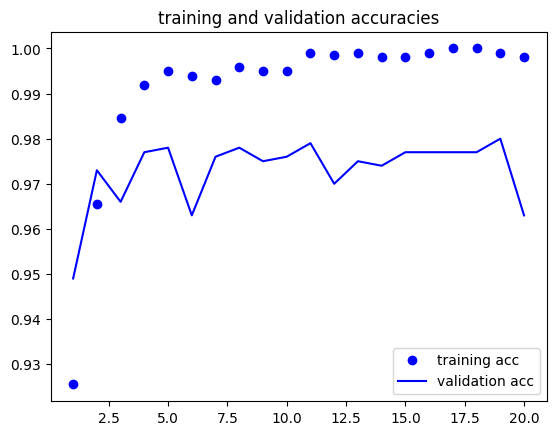

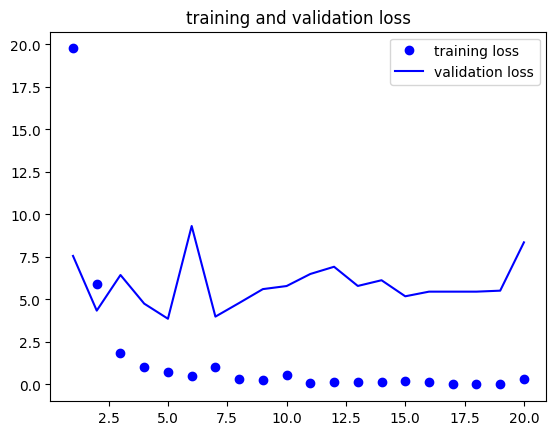

In [18]:
# plotting accuracy and loss curves

import matplotlib.pyplot as plt

acc = history.history["accuracy"]
loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="training acc")
plt.plot(epochs, val_acc, "b", label="validation acc")
plt.title("training and validation accuracies")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("training and validation loss")
plt.legend()
plt.show()

Now let's use the pretrained model in the second way.

### Feature extraction together with data augmentation

- Slower and more expensive.
- Allows for data augmentation during training.
- Creating a model that chains the `conv_base` with a new dense classifier, and train it end to end on the inputs.

### Instantiating and freezing the VGG16 conv base

In [19]:
# freezing means preventing the weight of the layer(s) from being updated
# done by setting the layer's trainable attribute to False

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False
)

conv_base.trainable = False # freezing the layer

In [20]:
# printing the trainable weights before and after freezing

conv_base.trainable = True
print("number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))

conv_base.trainable=False
print("number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

number of trainable weights before freezing the conv base: 26
number of trainable weights after freezing the conv base: 0


Alright, now let's create a new model to chain together
1. Data augmentation stage
2. Frozen convolutional base
3. Dense classifier

In [24]:
data_aug = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_aug(inputs)      # applying the data augmentation
x = keras.applications.vgg16.preprocess_input(x)  # applying the input value scaling
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# for these changes to take place, compile the model first
# if weight trainability is modified after compilation, gotta recompile or
# the changes will be ignored
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# now only weights form the 2 Dense layers added will be trained:
# 4 weight tensors (2 per layer): weight matrix and bias vector

In [25]:
# training the model
# will take longer to overfit, thanks to data aug^n

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extract_and_data_aug.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs = 50, validation_data = validation_dataset,
    callbacks=callbacks
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - accuracy: 0.8469 - loss: 40.4601 - val_accuracy: 0.9670 - val_loss: 4.4905
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.9475 - loss: 5.2757 - val_accuracy: 0.9760 - val_loss: 3.1400
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9388 - loss: 7.8372 - val_accuracy: 0.9680 - val_loss: 6.1005
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.9586 - loss: 5.3997 - val_accuracy: 0.9610 - val_loss: 8.0476
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.9652 - loss: 4.9862 - val_accuracy: 0.9660 - val_loss: 5.7620
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.9692 - loss: 3.3768 - val_accuracy: 0.9720 - val_loss: 4.5053
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.9797 - loss: 2.5004 - val_accuracy: 0.9760 - val_loss: 3.6992
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.9723 - loss: 4.0302 - val_accu

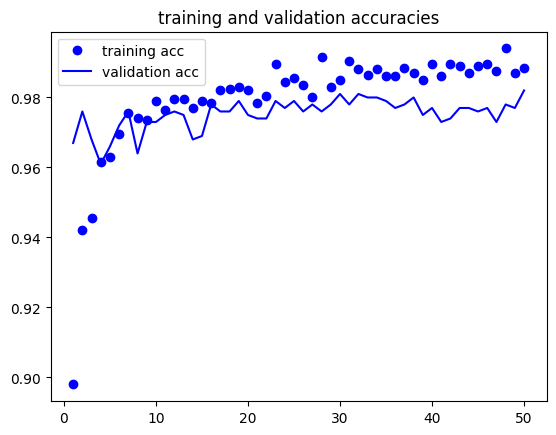

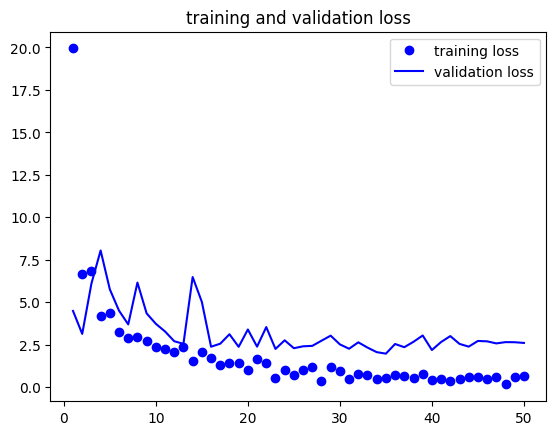

In [26]:
# plotting the acc and loss curves

import matplotlib.pyplot as plt

acc = history.history["accuracy"]
loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="training acc")
plt.plot(epochs, val_acc, "b", label="validation acc")
plt.title("training and validation accuracies")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("training and validation loss")
plt.legend()
plt.show()

In [27]:
# evaluation on test set

test_model = keras.models.load_model(
    "feature_extract_and_data_aug.keras"
)

test_loss, test_acc = test_model.evaluate(test_dataset)

print(f"test acc: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9806 - loss: 1.9489
test acc: 0.978


## 8.3.2 Fine-tuning a pretrained model

- *Fine-tuning* consists of unfreezing a few of the top layers of a froxen model base used for feature extraction.
- Then jointly training the newly added classifier (in this case) and these top layers.
- Called fine-tuninng as it slightly adjusts the more abstract representations of the model.

- Only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained.
- If it isn't trained, error propagated will be too large and the representations previously learned will go to waste.

Steps:
1. Add custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part newly added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part we added.

In [28]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### Freezing all layers until the 4th from the last

In [29]:
conv_base.trainable=True
for layer in conv_base.layers[:-4]:
  layer.trainable=False

### Fine-tuning the model

- Use RMSprop optimizer.
- Low learning rate. (as we wanna limit the modifications to the representations of the 3 layers being fine-tuned).

In [33]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tune.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=30, validation_data = validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.9862 - loss: 0.7604 - val_accuracy: 0.9820 - val_loss: 1.7129
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.9914 - loss: 0.2484 - val_accuracy: 0.9810 - val_loss: 1.9472
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.9923 - loss: 0.2766 - val_accuracy: 0.9800 - val_loss: 2.0400
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.9913 - loss: 0.4456 - val_accuracy: 0.9800 - val_loss: 1.8032
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.9859 - loss: 0.5669 - val_accuracy: 0.9830 - val_loss: 1.5097
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.9950 - loss: 0.1242 - val_accuracy: 0.9810 - val_loss: 1.8836
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9934 - loss: 0.2593 - val_accuracy: 0.9780 - val_loss: 2.4998
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 207ms/step - accuracy: 0.9907 - loss: 0.5400 - val_accu

In [34]:
# evaluate:

model = keras.models.load_model("fine_tune.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"test acc: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9803 - loss: 1.7055
test acc: 0.977
